
# MMF1921/MIE377 Style Backtesting Template

From the MIE377/MMF1921 Projects:

        The purpose of this program is to provide a template with which to develop Project 2. The project requires you to test different models  (and/or different model combinations) to create an asset management algorithm.

        This template will be used by the instructor and TA to assess your trading algorithm using different datasets.

        # PLEASE DO NOT MODIFY THIS TEMPLATE (for Project submission purposes)

This template for evaluating asset allocation algorithms is the exact same style as the one in MIE377.

Is it fast? No it is not.

Is it clear and relatively easy to follow? Yes it is.

There are a couple of moving parts:

* The database: see the Database folder for examples of where and how the data was processed. Download SQLLite viewer to explore the data and look at the queries in the notebooks to understand what data is in there
* The services: in the services folder there are some helpers to extract the data (data_retrieval.py), estimate means and covariances (estimators.py), and optimizers (optimization.py)
* Strategies are also defined in the services folder. The current convention is that a strategy takes in data (returns and factor returns) and outputs an allocation.
* Typically, the strategies will use some form of estimator and an optimizer come up with allocations.

If you do not want to deal with the database then use the MIE377_Project_Main template and copy cells 2.1 and 2.2 into the appropriate spot
and replace 

        x[:,t] = project_function(periodReturns, periodFactRet)

with

        x[:,t] = Strategy.execute_strategy(periodReturns, periodFactRet) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);

# 1. Read input files

In [1]:
import time
import math

import numpy as np
import pandas as pd

from Database.services.database import Database
from sqlalchemy import inspect
from services.data_retreival import *
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.strategies import *
from services.optimization_layers import *
from services.optimization import *
from services.binary_optimization import *
from services.environment_functions import *
from services.big_m_strategies import *

Database.initialize("sqlite:///Database//financial_db.sqlite") #for courses replace this with a flat file
inspector = inspect(Database.engine)
print(inspector.get_table_names())

universe = 'SP'
imputation_method = 'Multivariate'
ticker_str = 'AAPL'
#exponential params


adjClose = pd.read_csv("flat_files/MonthlyAssetPrices"+ universe + ".csv", index_col=0, header = 1).iloc[1:,:]

daily_adjClose =  pd.read_csv("flat_files/DailyAssetPrices"+universe + ".csv", index_col=0, header = 1).iloc[1:,:]

TechnicalAnalysis = pd.read_csv("flat_files/TechnicalAnalysis" + universe + ".csv", index_col=[0,1])

if universe ==  'SP':
    FinancialRatios = pd.read_csv("flat_files/" + imputation_method + "WRDS.csv", index_col=[0,1])
    TechnicalAnalysis.index.names = FinancialRatios.index.names
    ContextualInfo = TechnicalAnalysis.merge(FinancialRatios, how = 'left', left_index=True, right_index=True)

else:
    TechnicalAnalysis.index.names = ['date', 'ticker']
    ContextualInfo = TechnicalAnalysis


['asset_id', 'currency_id', 'equities_series', 'equity_index_id', 'exchange_id', 'factor_id', 'factors', 'frequency_id', 'fundamentals', 'metric_id', 'source_id', 'ticker_id', 'ticker_index_membership', 'tiingo_tickers']


In [2]:
adjClose.index = pd.to_datetime(adjClose.index, format='%Y-%m-%d').tz_localize(None)
daily_adjClose.index = pd.to_datetime(daily_adjClose.index, format='%Y-%m-%d').tz_localize(None)
ContextualInfo.index = ContextualInfo.index.set_levels([pd.to_datetime(ContextualInfo.index.levels[0]).tz_localize(None), ContextualInfo.index.levels[1]])

In [3]:
print("The earliest possible start date")
max(daily_adjClose.index.unique()[0], ContextualInfo.index.get_level_values('date').unique()[0], adjClose.index.unique()[0])

The earliest possible start date


Timestamp('1996-11-30 00:00:00')

In [4]:
print("The latest possible start date")
min(daily_adjClose.index.unique()[-1], ContextualInfo.index.get_level_values('date').unique()[-1], adjClose.index.unique()[-1])

The latest possible start date


Timestamp('2023-04-21 00:00:00')

In [5]:
start_date = pd.to_datetime('1996-11-30', format = '%Y-%m-%d')

end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

# start_date = pd.to_datetime('2006-05-31', format = '%Y-%m-%d')
# 
# end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

factors = ('Mkt-RF', 'RF')

factorRet = get_monthly_factors(factors, start_date, end_date, Database)

factorRet = factorRet.droplevel(0, axis = 1)
factorRet.columns = [col.strip() for col in factorRet.columns]

In [6]:
adjClose = adjClose[start_date:end_date]
daily_adjClose = daily_adjClose[start_date:end_date]
idx = pd.IndexSlice
ContextualInfo = ContextualInfo.loc[idx[start_date:end_date, :], :]

In [7]:
# Initial budget to invest ($100,000)
initialVal = 100000

# Length of investment period (in months) - but actually units of data
investPeriod = 6

# divide the factor returns by 100
factorRet = factorRet/100

#rf and factor returns
#drop the first observation to align the dataset with the returns data that will
#result
factorRet = factorRet.iloc[1:, :]

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

In [8]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [9]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values) # risk adjusted returns
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [10]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# 2. Run your program

This section will run your Project1_Function in a loop. The data will be loaded progressively as a growing window of historical observations.
Rebalancing will take place after every loop

### 2.1 Some Standard Allocation Strategies

In [11]:
def SVMMVO(limit_time=30, MipGap=0.01, LogToConsole=True, Verbose=True, SolutionLimit=GRB.MAXINT, user_big_m=None,
           **kwargs):  # if kwargs does not have limit time and mipgap then

    mu, targetRet, Q, K, q, epsilon, period_Context, C, separable = unpack_kwargs(kwargs)

    bigMStrategy = kwargs['bigMStrategy']
    turnover_constraints = kwargs['turnover_constraints']
    previous_portfolio = kwargs['previous_portfolio']

    if turnover_constraints:
        turnover_limit = kwargs['turnover_limit']

    feasible_solution = True

    n, p = period_Context.shape
    mu = mu.squeeze()

    start = time.time()
    # compute big M here
    big_M_results, bigM, big_w_inf, big_b, big_xi = SVMMVO_check_bigM(user_big_m, LogToConsole,
                                                                      bigMStrategy, Verbose, kwargs)

    # if epsilon and C in big_M_results --> update epsilon and C: kappa
    if 'epsilon' in big_M_results.keys() and 'C' in big_M_results.keys():
        C, epsilon = big_M_results['C'], big_M_results['epsilon']
        if Verbose:
            print("C and epsilon updated from big M")
    # if the big M strategy yields feasibility information then
    # update the feasible solution flag
    if 'feasible_solution' in big_M_results.keys():
        feasible_solution = big_M_results['feasible_solution']

    if Verbose:
        print("Calculated Big M ", bigM)
        print("Calculated big W", big_w_inf)
        print("Calculated big b", big_b)
        print("Calculated big xi", big_xi)

    bigM_finish_time = time.time()

    m, x_vars, z_vars, w_vars, b_var, t_vars, xi_vars = CreateSVMMVOModel(mu, targetRet, Q, K, q, epsilon,
                                                                          bigM, big_w_inf,
                                                                          period_Context, C=C,
                                                                          separable=separable, limit_time=limit_time,
                                                                          MipGap=MipGap, LogToConsole=LogToConsole)

    m.Params.SolutionLimit = SolutionLimit
    if 'warm_start' in big_M_results.keys():
        warm_start = big_M_results['warm_start']
        x_vars.Start = warm_start['x_vals']
        z_vars.Start = warm_start['z_vals']
        w_vars.Start = warm_start['w_vals']
        b_var.Start = warm_start['b_val']
        t_vars.Start = warm_start['t_vals']
        #xi_vars.Start = warm_start['xi_vals']
        #print("Warm Start")
        m.Params.LogToConsole = True

    if previous_portfolio is not None and turnover_constraints:  # add turnover constraints
        absolute_delta = addTurnoverConstraints(m, x_vars, previous_portfolio, turnover_limit)

    if feasible_solution:  # if we are feasible to the best of our knowledge
        m.optimize()  # try to solve
        # model did not solve
        if m.status in (4, 3):  # ah turns out we are not feasible
            feasible_solution = False  # update the flag
    else:  # feasible_solution is already set to false
        # it must be because of the turnover constraint
        # compute the min turnover portfolio that satisfies the constraint
        if previous_portfolio is not None and turnover_constraints:
            if Verbose:
                print("Calculating the closest turnover portfolio...")
            smallestTurnoverModelSVMMVO(m, n, absolute_delta, separable, w_vars, xi_vars, epsilon, C)

    obj_value, gap2, x, z, w, t, b, xi = extractSVMMVOSolution(n, p, m, x_vars, z_vars, w_vars, t_vars, b_var, xi_vars)
    if Verbose:
        print("SVM MVO Objective Value ", obj_value)
        print("Norm of w ", np.power(w, 2).sum())
        print("Classification errors ", np.sum(xi))
    end = time.time()
    m.Params.LogToConsole = False
    return {'obj_value': obj_value, 'time': end - start, 'bigM_time': bigM_finish_time - start, 'optimality gap': gap2,
            'x': x, 'z': z, 'w': w, 't': t, 'b': b, 'xi': xi, 'feasible_solution': feasible_solution,
            'C':C, 'epsilon':epsilon}

In [76]:
# Some strategies (uncomment this or the next cell to pick a strategy to test)
# Strategy = general_strategy(sample_estimator, MVO, NumObs=48)  #the general strategy object takes an estimator function and an optimizer function
#                                                                #the only constraint is that the estimators outputs are the optimizers inputs
# investor preferences (static throughout the backtest)
hyperparam_search = False # True if model has hyperparams
optimizer = SVMMVO # CardMVO , MVO
estimator = exponential_weighted_estimator_shrinkage #
EstNumObs = 750
k = 6*20 #estimation horizon
alpha= 1 - 0.990 #estimation decay
return_premium = 2.0 #optimization premium

turnover_constraints = True
turnover_limit = 0.75 # 0.75, 1, 1.25
cardinality_ratio = 0.1 #optimization

MipGap = 0.05 # for portfolio optimizer
limit_time = 20 # for portfolio optimizer

target_return_strategy = premium_target # for portfolio optimizer to calculate return target
# mean_target, premium_target, ticker_return_target
target_return_strategy_args = ['premium'] # args for the return strategy

bigMStrategy = HyperparameterBigMStrategy #objectiveBigMStrategy #objectiveBigMStrategyTightening , objectiveBigMStrategy

bigM_limit_time=20 # for the feasible solution used to calculate big M
bigM_MipGap=0.05 # for the feasible solution used to calculate big M
bigM_SolutionLimit=10 # for the feasible solution used to calculate big <

SkipSOCP = True # flag to skip the SOCP
tightening_iter_lim = 1 # number of iterations of tightening to do

SVMMVO_bigM_time_limit = 5 # for computing a better solution in the tightening strategy
SVMMVO_MipGap=0.1 # for computing a better solution in the tightening strategy
SVMMVO_SolutionLimit=5 # for computing a better solution in the tightening strategy

SOCP_limit_time=10 # time limit for the SOCP's

ticker_index = tickers.get_loc(ticker_str) # the ticker we want to compare to if
#  we are using the ticker_return_target strategy

q = 3 #subset of features

C = 0.1 # separation importance
epsilon = 0.1 # regularization amount for SVM

separable = False # do not restrict the hyperplane to be separable

LogToConsole = False # display optimization results in the console
Verbose = False # print statements

hyperparams = {'C': list(np.geomspace(0.1, 100, 4)), 'epsilon': list(np.geomspace(0.1, 100, 4))} # hyperparams for hyperparam search
#q_alpha = 0.3187 # alpha for Q(t, a) = (1 - q_alpha) Q(t-1. a) + R(t, a)
q_alpha = 0.6838

kappa = 0.1 # 10 % risk/turnover tolerance 0.25, 0.5, 1, 1.25, 0.75, 1.1 
             # SP 0.25, 0.5, 1, 0.125
             # 0.025, 0.05, 0.1, 0.2, 0.4
investor_preferences = {'k':k, # horizon
                        'alpha':alpha, # decay
                        'premium':return_premium, # return premium preference
                        'EstNumObs':EstNumObs,
                        'ticker_index':ticker_index, # benchmark index for comparison used in place of return premium depending on the investors function to set r_min
                        'target_return_strategy':target_return_strategy, # strategy for setting return
                        'target_return_strategy_args': target_return_strategy_args, # args for return setting strategy
                        'turnover_limit':turnover_limit, # turnover limit
                        'turnover_constraints':turnover_constraints, # turnover limit choice (Y/N)
                        'cardinality_ratio': cardinality_ratio, # Pct of assets to invest in
                        'MipGap' : MipGap, 'limit_time':limit_time, # problem solving limits
    
                        'bigMStrategy':bigMStrategy,
                        'bigM_limit_time':bigM_limit_time,
                        'bigM_MipGap':bigM_MipGap,
                        'bigM_SolutionLimit':bigM_SolutionLimit,

                        'SkipSOCP':SkipSOCP,
                        'tightening_iter_lim':tightening_iter_lim,

                        'SVMMVO_bigM_time_limit':SVMMVO_bigM_time_limit,
                        'SVMMVO_MipGap':SVMMVO_MipGap,
                        'SVMMVO_SolutionLimit':SVMMVO_SolutionLimit,

                        'SOCP_limit_time':SOCP_limit_time,
                        'q':q,
                        'C':C,
                        'epsilon':epsilon,
                        'separable':separable,
                        'LogToConsole':LogToConsole,
                        'Verbose':Verbose,
                        'hyperparams':hyperparams,
                        'q_alpha':q_alpha,
                        'kappa':kappa}

Strategy = general_strategy(estimator, optimizer,
                            investor_preferences = investor_preferences)

Strategy.extract_estimation_info = populate_exponential_weighted_estimator_shrinkage
Strategy.extract_optimization_info = populate_kwargs

env = environment()
# see strategy script for different options OLS_RP() #OLS_MVO() #HistoricalMeanVarianceOptimization()

In [77]:

# Start of out-of-sample test period
testStart = returns.index[0] + pd.offsets.DateOffset(years=2)

# End of the first investment period
# testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days = 1)
testEnd = testStart + pd.offsets.MonthBegin(investPeriod) - pd.offsets.DateOffset(days = 1)

# End of calibration period
calEnd = testStart -  pd.offsets.DateOffset(days = 1)

In [78]:
print("Test Start", testStart)
print("Test End", testEnd)
print("Calibration End", calEnd)

Test Start 1998-12-31 00:00:00
Test End 1999-05-31 00:00:00
Calibration End 1998-12-30 00:00:00


In [79]:
# Total number of investment periods
NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

In [ ]:
# Number of assets
n  = len(tickers)
env.n = n

hyperparam_hist = {}
Q = None


# Preallocate space for the portfolio weights (x0 will be used to calculate
# the turnover rate)
x  = np.zeros([n, NoPeriods])
x0 = np.zeros([n, NoPeriods])

# Preallocate space for the portfolio per period value and turnover
currentVal = np.zeros([NoPeriods, 1])
turnover   = np.zeros([NoPeriods, 1])

# Initiate counter for the number of observations per investment period
toDay = 0

# Measure runtime: start the clock
start_time = time.time()

# Empty list to measure the value of the portfolio over the period
portfValue = []

for t in range(NoPeriods):
    # Subset the returns and factor returns corresponding to the current calibration period.
    periodReturns = returns[returns.index <= calEnd]
    periodFactRet = factorRet[factorRet.index <= calEnd]

    # take the last available contextual observations
    period_daily_adjClose = daily_adjClose[daily_adjClose.index <= calEnd]
    period_Context_idx = ContextualInfo.index.get_level_values('date') <= calEnd
    period_Context = ContextualInfo.iloc[period_Context_idx].groupby('ticker').last()

    env.periodReturns = periodReturns
    env.periodFactRet = periodFactRet
    env.period_daily_adjClose = period_daily_adjClose
    env.period_Context = period_Context
    # there should be a feature vector for each asset
    assert len(period_Context) == n
    # all the tickers should be aligned in the context and ticker dataset 
    assert (periodReturns.columns == period_Context.index).all()

    current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
    currentPrices = adjClose[current_price_idx]

    # Subset the prices corresponding to the current out-of-sample test period.
    periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
    periodPrices = adjClose[periodPrices_idx]

    assert len(periodPrices) == investPeriod
    assert len(currentPrices) == 1
    # Set the initial value of the portfolio or update the portfolio value
    if t == 0:
        currentVal[0] = initialVal
    else:
        currentVal[t] = currentPrices @  NoShares.values.T
        #Store the current asset weights (before optimization takes place)
        x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]
            #update the previous periods portfolio 
        env.previous_portfolio = x0[:,t]

    #----------------------------------------------------------------------
    # Portfolio optimization
    # You must write code your own algorithmic trading function
    #----------------------------------------------------------------------
    # add in the estimation info

    x[:,t] = Strategy.execute_strategy(periodReturns, periodFactRet, environment=env) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);

    # Calculate hyperparameter tables
    if hyperparam_search is True:
        Q, hyperparam_hist_t = Strategy.optimize_hyperparameters(t, currentVal, currentPrices, periodPrices, Q, environment = env)
        hyperparam_hist[t] = hyperparam_hist_t
        # Strategies hyperparameters are updated
        # Dictionary of results for hyperparameter history is populated
    # Calculate the turnover rate
    if t > 0:
        turnover[t] = np.sum(np.abs( x[:,t] - x0[:,t] ) )


    # Number of shares your portfolio holds per stock
    NoShares = x[:,t]*currentVal[t]/currentPrices

    # Update counter for the number of observations per investment period
    fromDay = toDay
    toDay   = toDay + len(periodPrices)

    # Weekly portfolio value during the out-of-sample window
    portfValue.append(periodPrices@ NoShares.values.T)


    # Update your calibration and out-of-sample test periods
    testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
    testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
    calEnd    = testStart - pd.offsets.DateOffset(days=1)

portfValue = pd.concat(portfValue, axis = 0)
end_time = time.time()

Set parameter TimeLimit to value 20
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 20
Set parameter TimeLimit to value 20
Set parameter MIPGap to value 0.05
Set parameter LogToConsole to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 1152 rows, 1149 columns and 86811 nonzeros
Model fingerprint: 0xa22c3f22
Model has 41186 quadratic objective terms
Variable types: 718 continuous, 431 integer (431 binary)
Coefficient statistics:
  Matrix range     [8e-06, 8e+02]
  Objective range  [6e-05, 6e-05]
  QObjective range [1e-05, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 8e+02]
User MIP start produced solution with objective 0.0165402 (0.04s)
Loaded user MIP start with objective 0.0165402
Presolve time: 0.10s
Presolved: 1254 ro

# 3. Results

In [ ]:
#Strategy.hyperparam_hist[0]['previous_hyperparams']
times = [time.localtime().tm_year, time.localtime().tm_mon, time.localtime().tm_mday, time.localtime().tm_hour, time.localtime().tm_min]
str_time = ''
for t in times:
    str_time += str(t)+"_"

In [ ]:
"images/"+str_time + optimizer.__name__ +".log"
import logging

In [ ]:
#--------------------------------------------------------------------------
# 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
#-----------------------------------------------------------------------
# Calculate the observed portfolio returns
portfRets = portfValue.pct_change(1).iloc[1:,:]

# Calculate the portfolio excess returns
portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

# Calculate the portfolio Sharpe ratio
Ret = 12*((portfExRets + 1).apply(gmean, axis=0) - 1)
Vol = (12**0.5)*(portfExRets.std())
SR = (12**0.5)*(((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std())

# Calculate the average turnover rate
avgTurnover = np.mean(turnover[1:])
# Remove all handlers associated with the root logger object.
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(filename="images/"+str_time + optimizer.__name__ +".log", encoding='utf-8', level=logging.DEBUG)
#logging.debug('This message should go to the log file')
#Print Sharpe ratio and Avg. turnover to the console
logging.info("kamma is "+ str(kappa))
logging.info("Elasped time is "+ str(end_time - start_time) + ' seconds')
logging.info('Annualized return: '+ str(Ret[0]))
logging.info('Annualized vol: '+ str(Vol[0]))
logging.info('Annualized Sharpe ratio: '+ str(SR[0]))
logging.info('Avg. turnover: '+ str(avgTurnover))
logging.shutdown()

print("kappa is "+ str(kappa))
print("Elasped time is "+ str(end_time - start_time) + ' seconds')
print('Annualized return: '+ str(Ret[0]))
print('Annualized vol: '+ str(Vol[0]))
print('Annualized Sharpe ratio: '+ str(SR[0]))
print('Avg. turnover: '+ str(avgTurnover))

### Observations
CardMVO
Elasped time is 7.369283199310303 seconds
Annualized return:  0.09412269540406903
Annualized vol:  0.1284546196132244
Annualized Sharpe ratio:  0.7327311052531356
Avg. turnover:  0.7735524394082158

Elasped time is 7.92903470993042 seconds
Annualized return:  0.09933642917170893
Annualized vol:  0.1413044477771614
Annualized Sharpe ratio:  0.7029957707231093
Avg. turnover:  0.8047008752317142


In [ ]:
value_target_index = initialVal*(1 + adjClose.pct_change(1).loc[portfValue.index, ticker_str]).cumprod()
time0 = value_target_index.index[0] -  pd.offsets.MonthEnd(1)
value_target_index.loc[time0] = initialVal
value_target_index.sort_index(inplace = True)
#value_target_index = initialVal*value_target_index.div(value_target_index.iloc[0])
portfValue.loc[time0] = initialVal
portfValue.sort_index(inplace = True)
portfValue[ticker_str] = value_target_index
portfValue.columns = ['Strategy', ticker_str]

In [ ]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.iloc[:,:].plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = True)
plt.savefig("images/"+str_time + optimizer.__name__ + "wealth.svg")

#--------------------------------------------------------------------------
# 3.3 Portfolio weights plot
#--------------------------------------------------------------------------
# Portfolio weights

fig2 = plt.figure(2);
x[x < 0] = 0
weights = pd.DataFrame(x, index = tickers)
weights.columns = [col + 1 for col in weights.columns]
if n <= 20:
    legend_bool = True
else:
    legend_bool = False
weights.T.plot.area(title = 'Portfolio weights',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = legend_bool, stacked = True)
if legend_bool:
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("images/weights_.svg");

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End

### 0.12% maximum absolute difference between the returns generated via Python and returns generated via MATLAB can be observed

### Terminal wealth between MATLAB and Python is within 0.1%

In [65]:
#x_prev = weights

<AxesSubplot:>

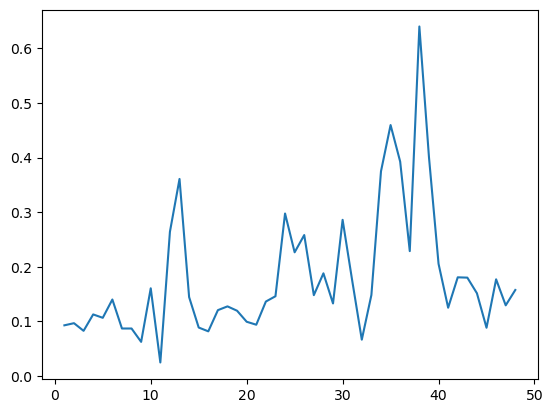

In [158]:
(x_prev - weights).abs().max(axis = 0).plot()

In [89]:
(x_prev - weights).loc[:, (x_prev - weights).abs().max(axis = 0) > 0.04]

,20,41,42,43,44,48
AAPL,0.0,0.000000,0.0,0.002311,0.00275,0.001386
ABT,0.0,0.000000,0.0,0.000000,0.00000,0.000000
ADBE,0.0,0.000000,0.0,0.000000,0.00000,0.000000
ADI,0.0,0.000000,0.0,0.000000,0.00000,0.000000
ADM,0.0,0.000000,0.0,0.000000,0.00000,0.000000
...,...,...,...,...,...,...
X,0.0,0.000000,0.0,0.000000,0.00000,0.000000
XRAY,0.0,0.000000,0.0,0.000000,0.00000,0.000000
XRX,0.0,0.000000,0.0,0.000000,0.00000,0.000000
ZBRA,0.0,0.000000,0.0,0.000000,0.00000,0.000000


In [86]:
weights.loc[(weights > 0.001).any(axis = 1), :]

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
AAPL,0.000000e+00,0.000000e+00,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.003692,0.002378,0.0045,0.004697,0.05102,0.052871
ADBE,0.000000e+00,-5.551115e-17,-0.00842,0.016096,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000
ADM,0.000000e+00,0.000000e+00,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000
ADSK,0.000000e+00,0.000000e+00,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000
AIG,0.000000e+00,0.000000e+00,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WEN,0.000000e+00,0.000000e+00,0.00000,0.000000,0.0,0.0,0.0,0.023442,-0.005398,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000
WMT,0.000000e+00,0.000000e+00,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.00000,-0.042730
WST,0.000000e+00,0.000000e+00,0.00000,0.000000,0.0,0.0,0.0,0.000000,-0.006691,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000
X,0.000000e+00,0.000000e+00,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000


In [43]:
(weights > 0.001).sum(axis = 0).max()

28

In [44]:
(np.abs(daily_adjClose.diff().dropna()) <= 0.001).sum().sort_values()

IBM      26
AMGN     37
KLAC     37
ADBE     39
CAT      39
       ... 
TYL     355
RAD     364
ODFL    429
VHI     470
SIG     527
Length: 286, dtype: int64

In [45]:
# Calculate the portfolio Sharpe ratio
ticker_rets = adjClose.pct_change(1).iloc[1:,]
ticker_rets = ticker_rets.loc[portfRets.index]

tickerExRets = ticker_rets.subtract(riskFree[(riskFree.index >= ticker_rets.index[0])&(riskFree.index <= ticker_rets.index[-1])], axis = 0)

tickerSR = ((tickerExRets + 1).apply(gmean, axis=0) - 1)/tickerExRets.std()

In [46]:
(12**0.5)*tickerSR.sort_values(ascending=False)

UNH     0.769529
ODFL    0.686024
CHD     0.682472
AZO     0.651169
ROL     0.642475
          ...   
AIG    -0.160984
XRX    -0.207712
PBI    -0.214084
UIS    -0.297995
RAD    -0.337033
Length: 286, dtype: float64

In [125]:
(12**0.5)*tickerSR[ticker_str]

-0.3393755249273548

In [80]:
sum(Strategy.current_results['w'] > 0)

0